## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [ ]:
#!pip install matplotlib
#!pip install numpy
#!pip install pandas
#!pip install imbalanced-learn

SyntaxError: invalid syntax (<ipython-input-73-d541d4297513>, line 4)

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau


from imblearn.over_sampling import SMOTE

**QUESTION:** Load dataset and display some lines of the csv file.

In [ ]:
df = pd.read_csv("../Jupiter/ai4i2020.csv")
print(df.head())

**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

In [ ]:
failure_counts = df['Machine failure'].value_counts()
failure_counts.plot(kind='bar', color=['#A2C4C9', '#F4A6A6'])
plt.xticks(ticks=[0, 1], labels=['No Failure', 'Failure'], rotation=0)
plt.ylabel('Count')
plt.title('Distribution of Machine Failures and Non-Failures')
plt.show()

**ANALYSIS QUESTION:** What do you observe?

"Write here your response"

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

"Write here your response"

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

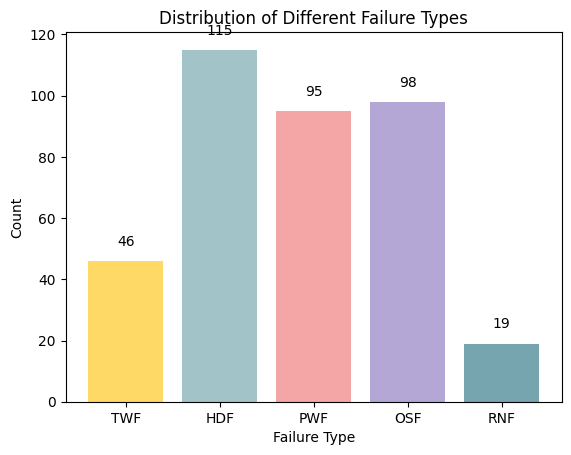

In [ ]:
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_counts = df[failure_types].sum()

colors = ['#FFD966', '#A2C4C9', '#F4A6A6', '#B4A7D6', '#76A5AF']
plt.bar(failure_counts.index, failure_counts.values, color=colors)
plt.xlabel('Failure Type')
plt.ylabel('Count')
plt.title('Distribution of Different Failure Types')
for i, v in enumerate(failure_counts.values):
    plt.text(i, v + 5, str(v), ha='center', fontsize=10)

plt.show()

**ANALYSIS QUESTION:** What do you observe?

"Write here your response"

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

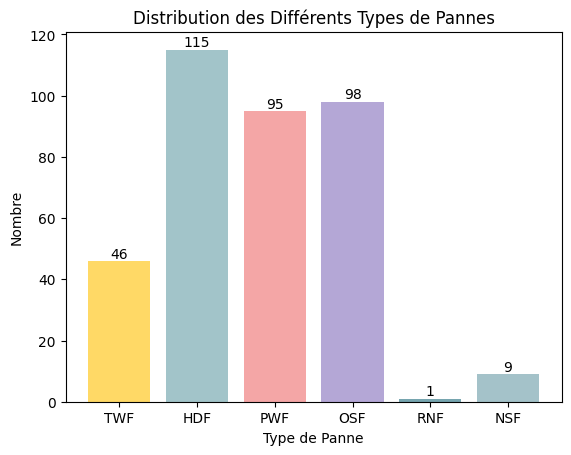

In [ ]:
failed_machines = df[df['Machine failure'] == 1]

failure_counts = failed_machines[failure_types].sum()

failure_counts['NSF'] = (failed_machines[failure_types].sum(axis=1) == 0).sum()


colors = ['#FFD966', '#A2C4C9', '#F4A6A6', '#B4A7D6', '#76A5AF', '#A4C2C9']
plt.bar(failure_counts.index, failure_counts.values, color=colors)
plt.xlabel('Type de Panne')
plt.ylabel('Nombre')
plt.title('Distribution des Différents Types de Pannes')

for i, count in enumerate(failure_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=10)

plt.show()


**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

"Write your response here"

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

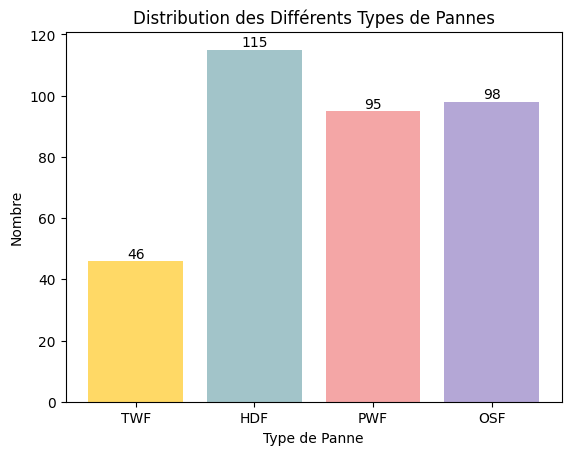

In [ ]:
#on enlève RNF car apparait qu'une seule fois, car Random donc difficile à prédire et 18 fois où RNF vaut 1 et Machine failure = 0 donc problème
#on enlève aussi les NSF: car on peut pas les prédire

failure_types_ok = ['TWF', 'HDF', 'PWF', 'OSF']
failed_machines = df[df['Machine failure'] == 1]

failure_counts = failed_machines[failure_types_ok].sum()


colors = ['#FFD966', '#A2C4C9', '#F4A6A6', '#B4A7D6']
plt.bar(failure_counts.index, failure_counts.values, color=colors)
plt.xlabel('Type de Panne')
plt.ylabel('Nombre')
plt.title('Distribution des Différents Types de Pannes')

for i, count in enumerate(failure_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=10)

plt.show()

**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

"Write your response here"

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [24]:
# 1. Supprimer les lignes où RNF == 1
df = df[df['RNF'] == 0]

# 2. Supprimer les lignes où Machine failure == 1 mais aucun type de défaillance spécifique n'est enregistré
failure_types_ok = ['TWF', 'HDF', 'PWF', 'OSF']
df = df[~((df['Machine failure'] == 1) & (df[failure_types_ok].sum(axis=1) == 0))]

# 3. Supprimer les lignes où il y a 2 erreurs ou plus en même temps
df = df[df[failure_types_ok].sum(axis=1) < 2]

# 4. Supprimer la colonne RNF
df = df.drop(columns=['RNF'])
# 5. Ajouter la colonne NF (inverse de Machine failure)
df['NF'] = (df['Machine failure'] == 0).astype(int)
# 6. Supprimer la colonne Machine failure
df = df.drop(columns=['Machine failure'])

# Afficher les premières lignes du dataset
print(df.head())
print(len(df))  # Nombre total de lignes

X = df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']]
Y = df[['TWF', 'HDF', 'PWF', 'OSF', 'NF']]

X_train, X_test, Y_train, Y_test = train_test_split (X, Y, test_size=0.2, random_state=42)

# Afficher le nombre d'éléments dans chaque ensemble
print(f"Nombre d'éléments dans X_train: {len(X_train)}")
print(f"Nombre d'éléments dans Y_train: {len(Y_train)}")
print(f"Nombre d'éléments dans X_test: {len(X_test)}")
print(f"Nombre d'éléments dans Y_test: {len(Y_test)}")

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  TWF  HDF  PWF  OSF  \
0                    1551         42.8                0    0    0    0    0   
1                    1408         46.3                3    0    0    0    0   
2                    1498         49.4                5    0    0    0    0   
3                    1433         39.5                7    0    0    0    0   
4                    1408         40.0                9    0    0    0    0   

   NF  
0   1  
1   1  
2   1  
3   1  
4   1  
9949
Nombre d'éléments dans X_train: 7959
No

**QUESTION** Code below the model architecture

In [ ]:
# Define the model
model = Sequential()

# Input layer and first hidden layer
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))

# Second hidden layer
model.add(Dense(32, activation='relu'))

# Output layer
model.add(Dense(Y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



# Print the model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                     │ (None, 64)                  │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,629 (10.27 KB)

 Trainable params: 2,629 (10.27 KB)

 Non-trainable params: 0 (0.00 B)

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

Epoch 1/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7127 - loss: 64.4066 - val_accuracy: 0.9643 - val_loss: 1.2052
Epoch 2/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9612 - loss: 0.4720 - val_accuracy: 0.9643 - val_loss: 0.3778
Epoch 3/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9680 - loss: 0.2173 - val_accuracy: 0.9623 - val_loss: 0.1820
Epoch 4/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9626 - loss: 0.1993 - val_accuracy: 0.9457 - val_loss: 0.2207
Epoch 5/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9634 - loss: 0.1789 - val_accuracy: 0.9638 - val_loss: 0.2141
Epoch 6/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9602 - loss: 0.2698 - val_accuracy: 0.9643 - val_loss: 0.4666
Epoch 7/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9666 - loss: 0.1918 - val_accuracy: 0.9648 - val_loss: 0.1434
Epoch 8/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9673 - loss: 0.1879 - val_accuracy: 0

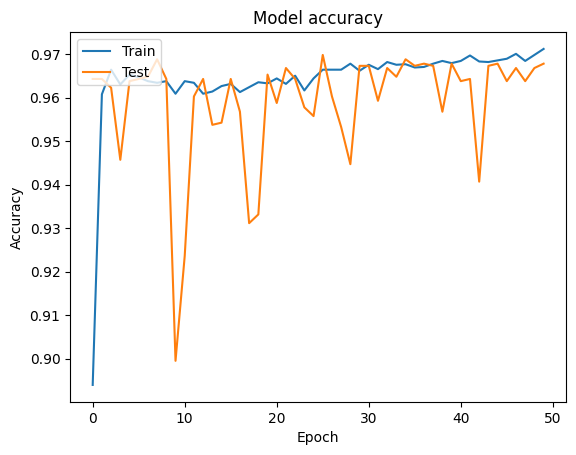

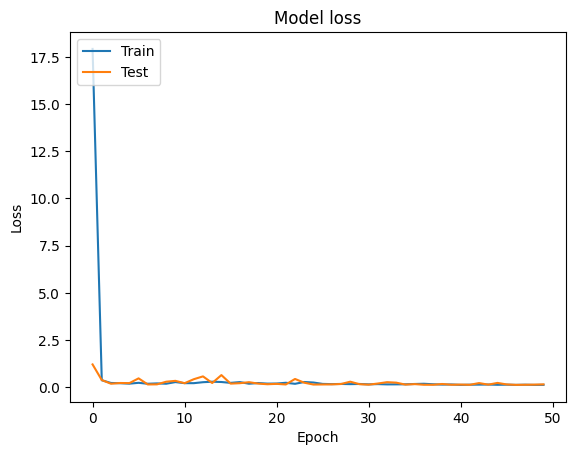

In [ ]:
# Train the model

history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**QUESTION** Plot the confusion matrix and the classification report



**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


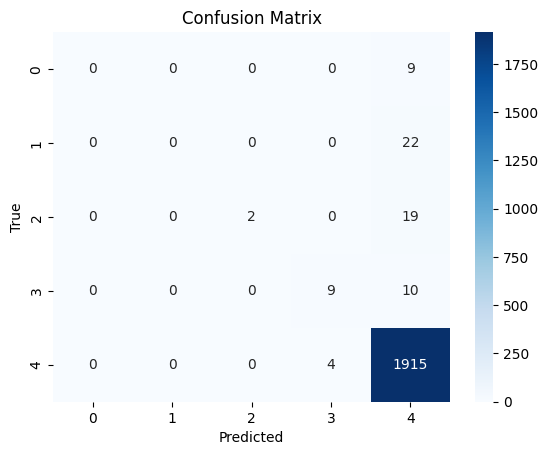

              precision    recall  f1-score   support

         TWF       0.00      0.00      0.00         9
         HDF       0.00      0.00      0.00        22
         PWF       1.00      0.10      0.17        21
         OSF       0.69      0.47      0.56        19
          NF       0.97      1.00      0.98      1919

    accuracy                           0.97      1990
   macro avg       0.53      0.31      0.34      1990
weighted avg       0.95      0.97      0.96      1990



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Predict the values from the test set
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true_classes = np.argmax(Y_test.values, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_true_classes, Y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(Y_true_classes, Y_pred_classes, target_names=['TWF', 'HDF', 'PWF', 'OSF', 'NF']))

**ANALYSIS QUESTION** What do you observe? What can you conclude?

**The model is experiencing instability during training.**
-  The loss values (both training and validation) are very high, which suggests that the model is struggling to learn effectively.
- The validation accuracy fluctuates significantly, especially in later epochs, which indicates potential overfitting or instability in the training process.
- The validation loss is also very high, which suggests that the model is not generalizing well to unseen data.

**The issues are likely due to the following:**
- The dataset is likely highly imbalanced, meaning one or more classes (e.g., "No Failure") dominate the dataset. This can cause the model to prioritize the majority class and perform poorly on minority classes.
- The categorical_crossentropy loss function assumes a balanced dataset. If the dataset is imbalanced, the model may not learn effectively.

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [ ]:
#df = df[df[failure_types_ok].sum(axis=1) < 2]
# Afficher les premières lignes du dataset

X_2 = df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']]
Y_2= df[['TWF', 'HDF', 'PWF', 'OSF', 'NF']]

# Combiner les labels en une seule colonne
Y_train_2['combined_label'] = Y_train_2.idxmax(axis=1)
Y_test_2['combined_label'] = Y_test_2.idxmax(axis=1)

# Afficher les nouvelles colonnes
print(Y_train_2['combined_label'].head())



# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_balanced, Y_train_balanced = smote.fit_resample(X_train_2, Y_train_2['combined_label'])

# Print the shapes after balancing
print(f"Shape of X_train_balanced: {X_train_balanced.shape}")
print(f"Shape of Y_train_balanced: {Y_train_balanced.shape}")
#Verify Class Distribution
# Before balancing
print("Class distribution before balancing:")
print(Y_train.sum(axis=0))

# After balancing
print("Class distribution after balancing:")
print(Y_train_balanced.sum(axis=0))

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  TWF  HDF  PWF  OSF  \
0                    1551         42.8                0    0    0    0    0   
1                    1408         46.3                3    0    0    0    0   
2                    1498         49.4                5    0    0    0    0   
3                    1433         39.5                7    0    0    0    0   
4                    1408         40.0                9    0    0    0    0   

   NF  
0   1  
1   1  
2   1  
3   1  
4   1  
9949


TypeError: '>' not supported between instances of 'str' and 'int'

**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

Analysis of Balancing Choices

    Why SMOTE?

        SMOTE generates synthetic samples for minority classes, which helps the model learn better representations of these classes.

        It avoids the loss of information that occurs with undersampling.

    Why Not Undersampling?

        Undersampling reduces the majority class size, which can lead to loss of important information.

        It’s not ideal for datasets where the majority class is still important for the model to learn.

    Why Not Class Weighting Alone?

        Class weighting adjusts the loss function to penalize errors on minority classes more heavily.

        However, it doesn’t address the issue of insufficient data for minority classes. Combining SMOTE with class weighting often yields better results.

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

In [ ]:
# Define the model
model = Sequential()

# Input layer and first hidden layer
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))

# Second hidden layer
model.add(Dense(32, activation='relu'))

# Output layer
model.add(Dense(Y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

**QUESTION** Code below the algorithms allowing to train model


In [ ]:
# Train the model on the balanced data
history = model.fit(
    X_train_balanced, Y_train_balanced,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, Y_test)
)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**QUESTION** Plot the confusion matrix and the classification report

In [ ]:
# Predict the values from the test set
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true_classes = np.argmax(Y_test.values, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_true_classes, Y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(Y_true_classes, Y_pred_classes, target_names=['TWF', 'HDF', 'PWF', 'OSF', 'NF']))

**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"